In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [29]:
def clean_csv_data(path, cols):
    # 使用pd.read_csv读取CSV数据并将其存储到DataFrame中
    df = pd.read_csv(path)
    
    # 选择指定的列
    df = df[cols]
    
    # 删除包含缺失值的行
    df.dropna(inplace=True)
    
    # 如果需要筛选 'availability_365' 大于等于30的行，可以取消下一行的注释
    df = df[df['availability_365'] >= 30]
    
    return df

In [30]:
years = ['2020', '2021', '2022', '2023']
csv_files=["/home/jovyan/work/FSDS_Groupwork/FSDS_GroupAssignment_Data/Data/listings_2020.csv",
"/home/jovyan/work/FSDS_Groupwork/FSDS_GroupAssignment_Data/Data/listings_2021.csv",
"/home/jovyan/work/FSDS_Groupwork/FSDS_GroupAssignment_Data/Data/listings_2022.csv",
"/home/jovyan/work/FSDS_Groupwork/FSDS_GroupAssignment_Data/Data/listings_2023.csv"]

cols = ['id', 'last_scraped',  'host_id', 'host_name', 'host_is_superhost', 
        'host_listings_count', 'host_total_listings_count',  'latitude', 'longitude', 
        'property_type', 'room_type', 'accommodates', 'price', 'minimum_nights', 'maximum_nights', 
        'availability_365', 'number_of_reviews', 
        'first_review', 'last_review', 'review_scores_rating', 'reviews_per_month']


for year, csv_file in zip(years, csv_files):
    df = clean_csv_data(csv_file, cols)
    output_file = f"/home/jovyan/work/FSDS_Groupwork/FSDS_GroupAssignment_Data/Data/cleaned_data_{year}.csv"
    df.to_csv(output_file, index=False)


/tmp/ipykernel_296597/3160282293.py:3: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


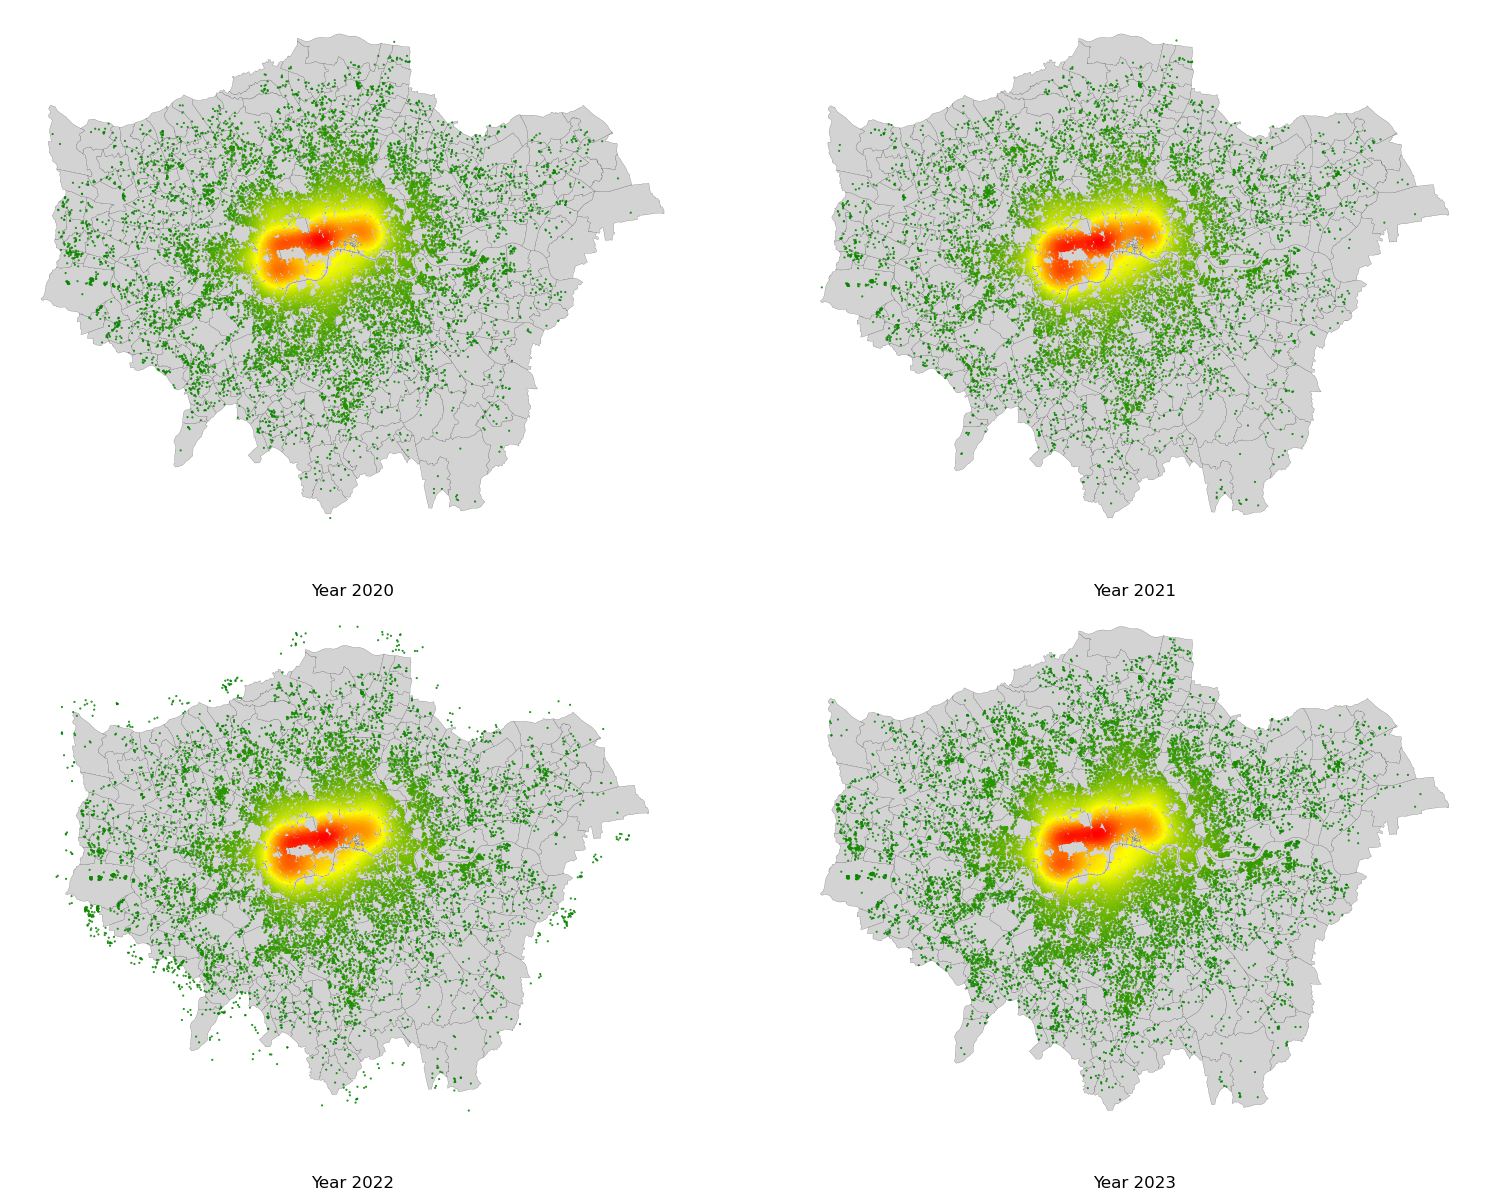

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()
# 读取伦敦矢量图
london_vector_map = gpd.read_file("/home/jovyan/work/FSDS_Groupwork/FSDS_GroupAssignment_Data/Borough/London_Ward/London_Ward.shp")
london_vector_map = london_vector_map.to_crs('EPSG:4326')
for i, year in enumerate(years):  # 使用enumerate获取年份索引
    # 读取清洗后的数据
    csv_file = f"/home/jovyan/work/FSDS_Groupwork/FSDS_GroupAssignment_Data/Data/cleaned_data_{year}.csv"
    df = pd.read_csv(csv_file)
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    geo_df = gpd.GeoDataFrame(df, geometry=geometry)
    # 计算核密度估计
    x = df['longitude']
    y = df['latitude']
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method='silverman')
    kde_values = kde(xy)

    # 创建颜色映射
    colors = [(0, 'green'), (0.5, 'yellow'), (1, 'red')]
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

    # 将密度值归一化并映射到颜色
    norm_kde_values = kde_values / max(kde_values)
    colors = cmap(norm_kde_values)

    # 绘制地图
    ax = axes[i]

    # 绘制伦敦矢量图
    london_vector_map.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.1)

    # 绘制缩小后的热力图点
    geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='EPSG:4326')
    geo_df.plot(ax=ax, marker='o', color=colors, markersize=0.25)

    # 添加年份标签
    ax.text(0.5, -0.1, f"Year {year}", size=12, ha='center', transform=ax.transAxes)

    # 调整坐标轴可见性
    ax.set_axis_off()

plt.tight_layout()
plt.show()
